In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit, expit
from scipy.stats import uniform, norm, bernoulli, mannwhitneyu
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
from modeltools import mcmc_diagnostics, create_summary_stat
from downcast import downcast_df
from simulatescores import simulate_scores

In [2]:
#  Setting up seeds
seed = 42

# Setting numpy seed
np.random.seed(seed)

In [73]:
import sys
import importlib
importlib.reload(sys.modules['simulatescores'])
from simulatescores import simulate_scores

In [4]:
raw_data = pd.read_csv("data/unit_level_ratings.csv",index_col = 0)
raw_data = raw_data.sort_values(by=["corpus", "model", "topic"])

In [5]:
# Creating identifier for each corpus, model, and topic
# Identifier is unique for topic 
corpus_ids = (raw_data.groupby(["corpus"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
corpus_ids["corpus_id"] = corpus_ids.index

model_ids = (raw_data.groupby(["model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
model_ids["model_id"] = model_ids.index

cordel_ids = (raw_data.groupby(["corpus", "model"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
cordel_ids["cordel_id"] = cordel_ids.index 

topic_ids = (raw_data.groupby(["corpus", "model", "topic"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
topic_ids["topic_id"] = topic_ids["topic"].astype(np.int16)

rater_ids = (raw_data.groupby(["corpus", "rater"], as_index=False)
    .agg({"intrusion":"count"})
    .drop(columns="intrusion"))
rater_ids["rater_id"] = rater_ids.index 


d1 = pd.merge(raw_data, corpus_ids, on=["corpus"], how="left")
d2 = pd.merge(d1, model_ids, on=["model"], how="left")
d3 = pd.merge(d2, cordel_ids, on=["corpus","model"], how="left")
d4 = pd.merge(d3, rater_ids, on=["corpus", "rater"], how="left")
data = pd.merge(d4, topic_ids, on=["corpus", "model", "topic"], how="left")
data = data[["corpus_id", "model_id", "cordel_id", "topic_id", "rater_id", "intrusion", "confidence"]]
data, na_s = downcast_df(data)

In [6]:
# Setting up numpy arrays for pymc
corpus_array = np.array(data["corpus_id"])
n_corpora = data["corpus_id"].nunique()

model_array = np.array(data["model_id"])
n_models = data["model_id"].nunique()

cordel_array = np.array(data["cordel_id"])
n_cordels = data["cordel_id"].nunique()

topic_array = np.array([data["cordel_id"], data["topic_id"]])
n_topics = data["topic_id"].nunique()

rater_array = np.array(data["rater_id"])
n_raters = data["rater_id"].nunique()

score_array = np.array(data["intrusion"])

## Bayesian Model

In [7]:
# Model and MCMC specifications

n_cores = 2
empirical_mean = logit(0.75)
r_lambda = 2
t_lambda = 1
t_sigma = 1
# cm_lambda = 2
# cm_sigma = 1
mu_sigma = 1

glm_rater_topic_cordel = {"model":pm.Model()}

In [8]:
# Rater, Topic, Cordel model

glm_rater_topic_cordel["model"] = pm.Model()
with glm_rater_topic_cordel["model"]:
    # Hyperparameter priors
    raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
    topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
    cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")
    
    sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
    zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
    sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
    za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
    mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)
    
    s = pm.Bernoulli(
            "s", 
            p=pm.math.invlogit(
                mu[cordels]+
                za[topics[0],topics[1]]*sigma_a+
                zr[raters]*sigma_r),
            observed=score_array, 
            dims="obs_id")

    c_mean = pm.Deterministic("c_mean", 
                              pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                              dims="obs_id")
    
    glm_rater_topic_cordel["trace"]=pm.sample(cores=n_cores, random_seed=seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 269 seconds.


In [9]:
glm_rater_topic_cordel["summary_stat"] = create_summary_stat(glm_rater_topic_cordel["trace"])

## Functions

In [53]:
def create_sim_df(variables, ranges, n_trials):
# variables = ["p_diff", "n_ratings"]
# ranges = [(0.02, 0.2), (20, 100)]
# n_trials = 10

    var0 = uniform.rvs(loc = ranges[0][0], scale=ranges[0][1]-ranges[0][0], size=n_trials)
    var1 = uniform.rvs(loc = ranges[1][0], scale=ranges[1][1]-ranges[1][0], size=n_trials)
    df = pd.DataFrame(np.array([
        var0, var1, 
        np.empty(n_trials, dtype=np.int8),
        np.empty(n_trials, dtype=np.int8)
    ]).T, columns=variables+["utest_pval", "bht_pval"])
    df["n_raters"] = df["n_raters"].astype(int)
    df["utest_pval"] = np.NaN
    df["bht_pval"] = np.NaN

    return df

In [66]:
def utest_pval(scores):
    # Utests whether the two distributions in the scores are statisticaly significant
    # returns 1 if cordel 1 intrusion scores is statistically higher
    # returns 0 if no statistical difference
    # returns -1 if cordel 2 intrusion scores are statistically higher 

    sums = scores.groupby(["sim_cordel_id", "sim_topic_id"]).agg({"intrusion":"sum"}).reset_index()
    cordel0_intrusions = sums[sums["sim_cordel_id"]==0]["intrusion"]
    cordel1_intrusions = sums[sums["sim_cordel_id"]==1]["intrusion"]
    result = mannwhitneyu(cordel0_intrusions, cordel1_intrusions, alternative="two-sided")[1]
    
    return result


In [ ]:
# def bht_pval(sample):
# sample = scores[scores["sim_id"]==0]

# Bayesian hypothesis tests whether the two distributions in the sample are statisticaly significant
# Setting up numpy arrays for pymc
# Only 2 models and 1 corpus in simulation
    corpus_array = np.array([0]*len(sample))
    n_corpora = 1

    model_array = np.array(sample["sim_cordel_id"])
    n_models = sample["sim_cordel_id"].nunique()

    cordel_array = np.array(sample["sim_cordel_id"])
    n_cordels = sample["sim_cordel_id"].nunique()

    topic_array = np.array([sample["sim_cordel_id"], sample["sim_topic_id"]])
    n_topics = sample["sim_topic_id"].nunique()

    rater_array = np.array(sample["sim_rater_id"])
    n_raters = sample["sim_rater_id"].nunique()

    score_array = np.array(sample["intrusion"])


    # Model and MCMC specifications
    n_cores = 2
    empirical_mean = logit(0.75)
    r_lambda = 2
    t_lambda = 1
    t_sigma = 1
    # cm_lambda = 2
    # cm_sigma = 1
    mu_sigma = 1

    glm = {"model":pm.Model()}

    # Rater, Topic, Cordel model

    glm["model"] = pm.Model()
    with glm["model"]:
        # Hyperparameter priors
        raters = pm.Data("raters", rater_array, mutable=True, dims="obs_id")
        topics = pm.Data("topics", topic_array, mutable=True, dims=["cordel", "topic"])
        cordels = pm.Data("cordels", cordel_array, mutable=True, dims="obs_id")

        sigma_r = pm.Exponential("sigma_r", lam=r_lambda)
        zr = pm.Normal("zr",mu=0, sigma=1, shape=n_raters)
        sigma_a = pm.Exponential("sigma_a", lam=t_lambda)
        za = pm.Normal("za",mu=0, sigma=t_sigma, shape=(n_cordels, n_topics)) 
        mu = pm.Normal("mu",mu=empirical_mean, sigma=mu_sigma, shape=n_cordels)

        s = pm.Bernoulli(
                "s", 
                p=pm.math.invlogit(
                    mu[cordels]+
                    za[topics[0],topics[1]]*sigma_a+
                    zr[raters]*sigma_r),
                observed=score_array, 
                dims="obs_id")

        c_mean = pm.Deterministic("c_mean", 
                                  pm.math.invlogit(mu + (za.T*sigma_a)).mean(axis=0), 
                                  dims="obs_id")
        c_diff = pm.Deterministic("c_diff", c_mean.reshape([n_cordels,1]) - c_mean.reshape([1,n_cordels]), dims="obs_id")

        glm["trace"]=pm.sample(cores=n_cores, progressbar=False)

    n_negatives = (glm["trace"].posterior["c_diff"].sel({"obs_id":1, "c_diff_dim_1":0}) < 0).sum().item()
    
    return  n_negatives/len(sample)

## Simulation

In [ ]:
scatter. colour is two significance tests
p values vs n_raters
p values vs topics_per_r (holding number of total ratings constant)

n_raters vs p_diff

In [87]:
# Simulation setup
topics_per_r = 40
n_trials = 5
alpha = 0.05
np.random.seed(seed)

In [ ]:
n_raters_results = create_sim_df(
    variables = ["p_diff", "n_raters"],
    ranges = [(0.02, 0.2), (20, 100)],
    n_trials = 10)

In [88]:
# Simulating scores and significance tests
for i in range(n_trials):
    print(f"Trial: {i}")
    p_diff = n_raters_results.loc[i, "p_diff"].item()
    n_raters = n_raters_results.loc[i, "n_raters"].item()
    scores = simulate_scores(
        glm_rater_topic_cordel,
        p_diff=p_diff,
        n_raters=n_raters,
        topics_per_r=topics_per_r,
        n_sims=1)
    n_raters_results.loc[i, "utest_pval"] = utest_pval(scores)
    n_raters_results.loc[i, "bht_pval"] = bht_pval(scores)

Completed simulating topic/rater interactions in 0.61s
Completed simulating scores in 0.68s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 25 seconds.


Completed simulating topic/rater interactions in 0.78s
Completed simulating scores in 0.86s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.


Completed simulating topic/rater interactions in 0.72s
Completed simulating scores in 0.79s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 66 seconds.


Completed simulating topic/rater interactions in 0.57s
Completed simulating scores in 0.63s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 37 seconds.


Completed simulating topic/rater interactions in 0.59s
Completed simulating scores in 0.67s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_r, zr, sigma_a, za, mu]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 33 seconds.


In [90]:
a = n_raters_results.copy(deep=True)

In [95]:
n_raters_results["utest"] = n_raters_results["utest_pval"] < alpha
n_raters_results["bht"] = n_raters_results["bht_pval"] < alpha

# (utest, bht)
# Neither significant: orange
# bht significant: yellow
# utest significant: blue
# both significant: green

n_raters_results["c"] = np.select(
    condlist=[
        ~n_raters_results["utest"] & ~n_raters_results["bht"],
        ~n_raters_results["utest"] & n_raters_results["bht"],
        n_raters_results["utest"] & ~n_raters_results["bht"],
        n_raters_results["utest"] & n_raters_results["bht"]
    ],
    choicelist=["orangered", "yellow", "blue", "green"],
    default="black")


In [96]:
n_raters_results

,p_diff,n_raters,utest_pval,bht_pval,utest,bht,c
0,0.087417,21,0.251617,0.160714,False,False,orangered
1,0.191129,97,0.001180,0.000000,True,True,green
2,0.151759,86,0.008529,0.000000,True,True,green
3,0.127759,36,0.037855,0.000000,True,True,green
4,0.048083,34,0.778195,0.286029,False,False,orangered
5,0.048079,34,NaN,NaN,False,False,orangered
6,0.030455,44,NaN,NaN,False,False,orangered
7,0.175912,61,NaN,NaN,False,False,orangered
8,0.128201,54,NaN,NaN,False,False,orangered
9,0.147453,43,NaN,NaN,False,False,orangered


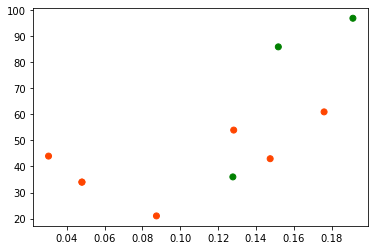

In [97]:
plt.scatter(n_raters_results["p_diff"], n_raters_results["n_raters"], c=n_raters_results["c"])
plt.show()

. \
. \
. \
. \
. \
. \
. \
. 
## Checking score simulation script

In [11]:
# Simulating scores
p_diff = 0.08
n_raters = 40
topics_per_r = 40
n_sims = 1_000
np.random.seed(seed)

In [13]:
scores = simulate_scores(
    glm_rater_topic_cordel,
    p_diff=p_diff,
    n_raters=n_raters,
    topics_per_r=topics_per_r)

Completed simulating topic/rater interactions in 562.68s
Completed simulating scores in 643.45s


In [15]:
sim_scores = scores.copy(deep=True)

Perc of simulations with mean1 < mean0 (n raters=40): 0.2%


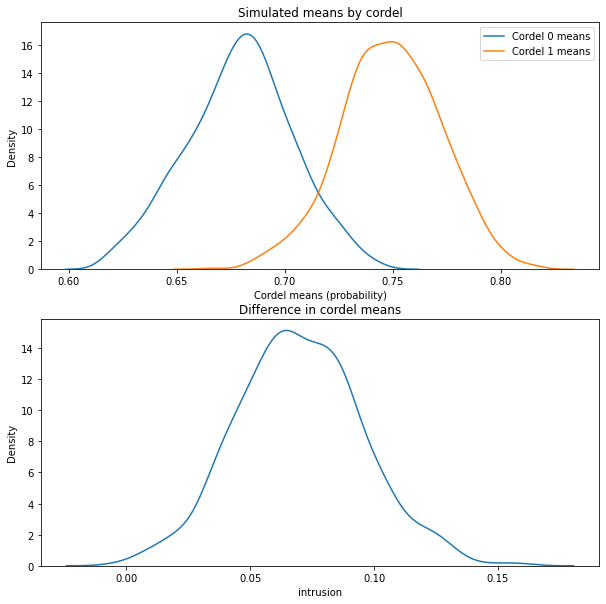

In [16]:
# Checking scores

_, ax = plt.subplots(2,1,figsize=(10,10))

n_ratings_per_cordel = n_raters*topics_per_r/2

sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
sns.kdeplot(sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"})["intrusion"]/n_ratings_per_cordel, ax=ax[0])
ax[0].legend(ax[0].get_lines(), ["Cordel 0 means", "Cordel 1 means"])
ax[0].set_xlabel("Cordel means (probability)")
ax[0].set_title(f"Simulated means by cordel")

diff = sim_scores[sim_scores["sim_cordel_id"]==1].groupby(["sim_id"]).agg({"intrusion":"sum"}) \
        - sim_scores[sim_scores["sim_cordel_id"]==0].groupby(["sim_id"]).agg({"intrusion":"sum"})

sns.kdeplot(diff["intrusion"]/n_ratings_per_cordel, ax=ax[1])
ax[1].set_title(f"Difference in cordel means")
plt.plot()

print(f"Perc of simulations with mean1 < mean0 (n raters={n_raters}): {(diff['intrusion']<=0).sum()/1000:.1%}")

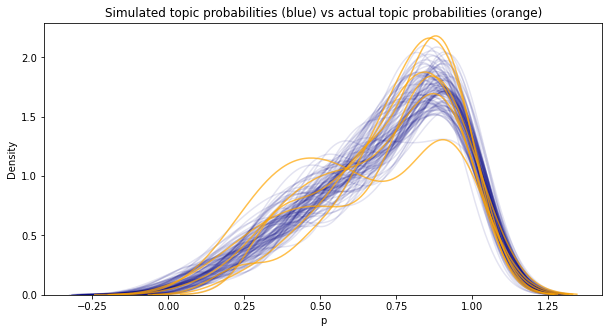

In [17]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating topic proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=7/size**0.9)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["cordel_id", "topic_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for cordel_id in range(6):
    sns.kdeplot(actuals[actuals["cordel_id"]==cordel_id]["p"], ax=ax, color="orange", alpha=0.7)

ax.set_title("Simulated topic probabilities (blue) vs actual topic probabilities (orange)")
plt.show()

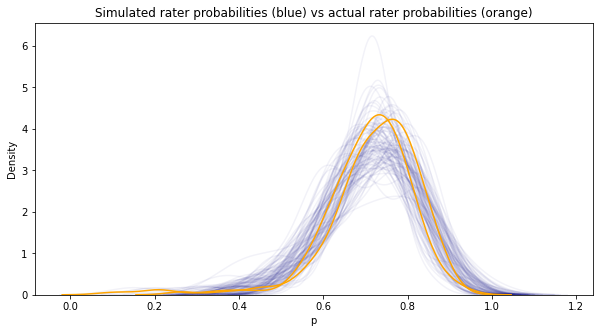

In [18]:
size=100

_, ax = plt.subplots(1,1,figsize=(10,5))


# Selecting 100 random simulations
rand_ids = np.random.choice(range(1000), size=size, replace=False)

# Calculating rater proportions
samples = (sim_scores[sim_scores["sim_id"].isin(rand_ids)].groupby(["sim_id", "sim_rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
samples["p"] = samples[("intrusion", "sum")]/samples[("intrusion", "count")]
# Plotting proportions
for sim_id in rand_ids:
    sns.kdeplot(samples[samples["sim_id"]==sim_id]["p"], ax=ax, color="navy", alpha=0.05)

# Repeat calculations and plots for actual data
actuals = (data.groupby(["corpus_id", "rater_id"])
           .agg({"intrusion":["sum", "count"]}).reset_index())
actuals["p"]=actuals[("intrusion", "sum")]/actuals[("intrusion", "count")]
for corpus_id in range(2):
    sns.kdeplot(actuals[actuals["corpus_id"]==corpus_id]["p"], ax=ax, color="orange", alpha=1)

ax.set_title("Simulated rater probabilities (blue) vs actual rater probabilities (orange)")
plt.show()